# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Import libraries

In [7]:
import matplotlib.pyplot as plt
import spacy
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (8,5)

from sklearn import datasets
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


In [8]:
nlp = spacy.load("en_core_web_sm")

## Data exploring

In [10]:

# 1) Load CSV
df = pd.read_csv('data/reviews.csv')

# 2) Engineered features
df['Review_Length'] = df['Review Text'].str.split().str.len()
df['Excl_Count']    = df['Review Text'].str.count('!')

# 3) Quick peek
df.info()
df[['Review Text','Review_Length','Excl_Count']].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
 9   Review_Length            18442 non-null  int64 
 10  Excl_Count               18442 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 1.5+ MB


,Review Text,Review_Length,Excl_Count
0,I had such high hopes for this dress and reall...,98,1
1,"I love, love, love this jumpsuit. it's fun, fl...",22,2
2,This shirt is very flattering to all due to th...,36,3
3,"I love tracy reese dresses, but this one is no...",98,0
4,I aded this in my basket at hte last mintue to...,101,0


## Data Snapshot: Recommendations & Key Metrics

In [12]:
# Let’s see how many people recommend our products
print("Recommendation counts:\n", df['Recommended IND'].value_counts())

# And here’s the same info as percentages
print("\nRecommendation proportions:\n", df['Recommended IND'].value_counts(normalize=True))

# A quick look at our main numbers: age, feedback, review length, excitement (!) counts
print("\nNumeric features summary:")
display(df[['Age', 'Positive Feedback Count', 'Review_Length', 'Excl_Count']].describe().T)

# How many unique categories do we have, and which ones show up the most?
for col in ['Division Name', 'Department Name', 'Class Name']:
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())


Recommendation counts:
 Recommended IND
1    15053
0     3389
Name: count, dtype: int64

Recommendation proportions:
 Recommended IND
1    0.816235
0    0.183765
Name: proportion, dtype: float64

Numeric features summary:


,count,mean,std,min,25%,50%,75%,max
Age,18442.0,43.383635,12.246264,18.0,34.0,41.0,52.0,99.0
Positive Feedback Count,18442.0,2.697484,5.942220,0.0,0.0,1.0,3.0,122.0
Review_Length,18442.0,62.449355,28.138528,2.0,39.0,62.0,90.0,115.0
Excl_Count,18442.0,0.622872,1.131936,0.0,0.0,0.0,1.0,41.0



Division Name: 2 unique values
Division Name
General           11664
General Petite     6778
Name: count, dtype: int64

Department Name: 6 unique values
Department Name
Tops        8713
Dresses     5371
Bottoms     3184
Jackets      879
Intimate     188
Name: count, dtype: int64

Class Name: 14 unique values
Class Name
Dresses     5371
Knits       3981
Blouses     2587
Sweaters    1218
Pants       1157
Name: count, dtype: int64


## Recommendations Breakdown & Key Feature Summary

In [14]:
# Check how many customers recommend our items
print("Recommendation counts:\n", df['Recommended IND'].value_counts())

# View those same numbers as percentages for easier comparison
print("\nRecommendation proportions:\n", df['Recommended IND'].value_counts(normalize=True))

# Quick snapshot of our main metrics: age, positive feedback, review length, and excitement 
print("\nNumeric features summary:")
display(df[['Age', 'Positive Feedback Count', 'Review_Length', 'Excl_Count']].describe().T)

# See how many unique categories we have and which ones top the list
for col in ['Division Name', 'Department Name', 'Class Name']:
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())


Recommendation counts:
 Recommended IND
1    15053
0     3389
Name: count, dtype: int64

Recommendation proportions:
 Recommended IND
1    0.816235
0    0.183765
Name: proportion, dtype: float64

Numeric features summary:


,count,mean,std,min,25%,50%,75%,max
Age,18442.0,43.383635,12.246264,18.0,34.0,41.0,52.0,99.0
Positive Feedback Count,18442.0,2.697484,5.942220,0.0,0.0,1.0,3.0,122.0
Review_Length,18442.0,62.449355,28.138528,2.0,39.0,62.0,90.0,115.0
Excl_Count,18442.0,0.622872,1.131936,0.0,0.0,0.0,1.0,41.0



Division Name: 2 unique values
Division Name
General           11664
General Petite     6778
Name: count, dtype: int64

Department Name: 6 unique values
Department Name
Tops        8713
Dresses     5371
Bottoms     3184
Jackets      879
Intimate     188
Name: count, dtype: int64

Class Name: 14 unique values
Class Name
Dresses     5371
Knits       3981
Blouses     2587
Sweaters    1218
Pants       1157
Name: count, dtype: int64


## Preparing features (X) & target (y)

In [16]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Review_Length,Excl_Count
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,98,1
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,22,2
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,36,3
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,98,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,101,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

## Data Exploration

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
 9   Review_Length            18442 non-null  int64 
 10  Excl_Count               18442 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 1.5+ MB


## Recommendation Distribution (Donut Chart)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      18442 non-null  int64 
 1   Title                    18442 non-null  object
 2   Review Text              18442 non-null  object
 3   Positive Feedback Count  18442 non-null  int64 
 4   Division Name            18442 non-null  object
 5   Department Name          18442 non-null  object
 6   Class Name               18442 non-null  object
 7   Recommended IND          18442 non-null  int64 
 8   Review_Length            18442 non-null  int64 
 9   Excl_Count               18442 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.4+ MB
None
                Age  Positive Feedback Count  Recommended IND  Review_Length  \
count  18442.000000             18442.000000     18442.000000   18442.000000   
mean      43.383635                 2.69

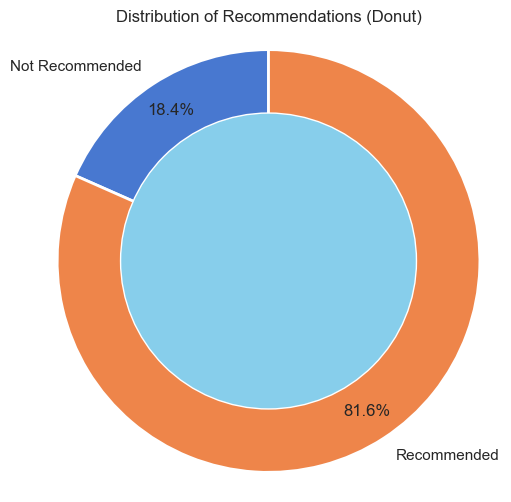

In [21]:
# Make a copy and drop the Clothing ID since we don’t need it
df = data.copy()
df.drop('Clothing ID', axis=1, inplace=True)

# Quick glance at structure and summary stats
print(df.info())
print(df.describe())

# Grab counts for each recommendation category
counts = df['Recommended IND'].value_counts().sort_index()
labels = ['Not Recommended', 'Recommended']

# Build a donut chart to show recommendation proportions
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
)

# Add a circle in the middle to turn the pie into a donut
centre_circle = plt.Circle((0,0), 0.70, fc='skyblue')
ax.add_artist(centre_circle)

# Ensure the chart is a perfect circle
ax.axis('equal')

plt.title('Distribution of Recommendations (Donut)')
plt.show()


## Four Key Exploratory Plots in One View

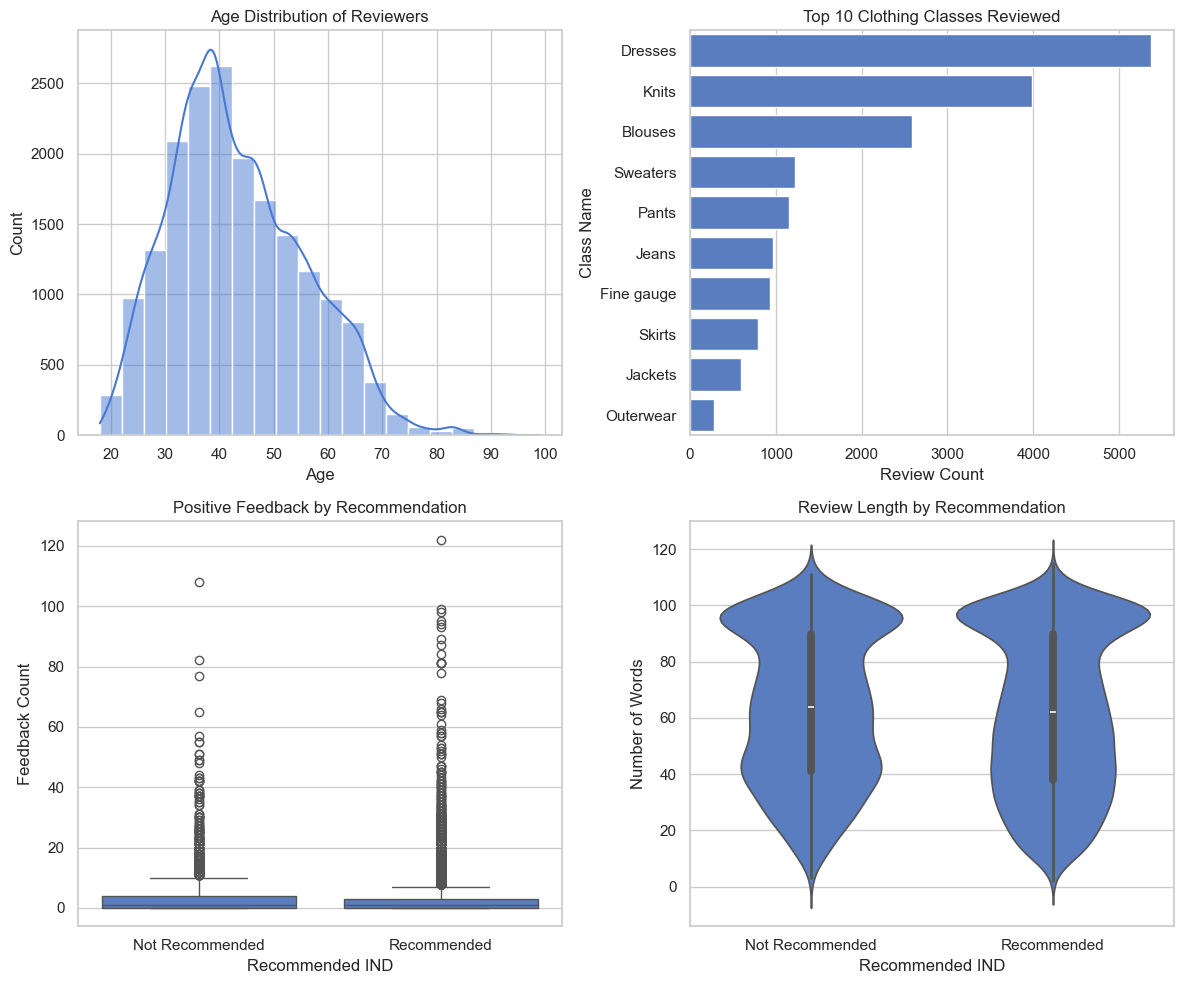

In [23]:
# Lay out a 2×2 grid so we can glance at four visuals together
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Show how reviewer ages spread out
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution of Reviewers')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# Highlight the top 10 most-reviewed product classes
top10 = df['Class Name'].value_counts().nlargest(10)
sns.barplot(x=top10.values, y=top10.index, ax=axes[1])
axes[1].set_title('Top 10 Clothing Classes Reviewed')
axes[1].set_xlabel('Review Count')
axes[1].set_ylabel('Class Name')

# Compare positive feedback counts between recommended vs. not
sns.boxplot(x='Recommended IND', y='Positive Feedback Count', data=df, ax=axes[2])
axes[2].set_xticks([0,1])
axes[2].set_xticklabels(['Not Recommended','Recommended'])
axes[2].set_title('Positive Feedback by Recommendation')
axes[2].set_ylabel('Feedback Count')

# See how review length shifts based on recommendation
sns.violinplot(x='Recommended IND', y='Review_Length', data=df, ax=axes[3])
axes[3].set_xticks([0,1])
axes[3].set_xticklabels(['Not Recommended','Recommended'])
axes[3].set_title('Review Length by Recommendation')
axes[3].set_ylabel('Number of Words')

# Tweak spacing so everything looks neat
plt.tight_layout()
plt.show()


## Cumulative Age Distribution (Capped at 70)

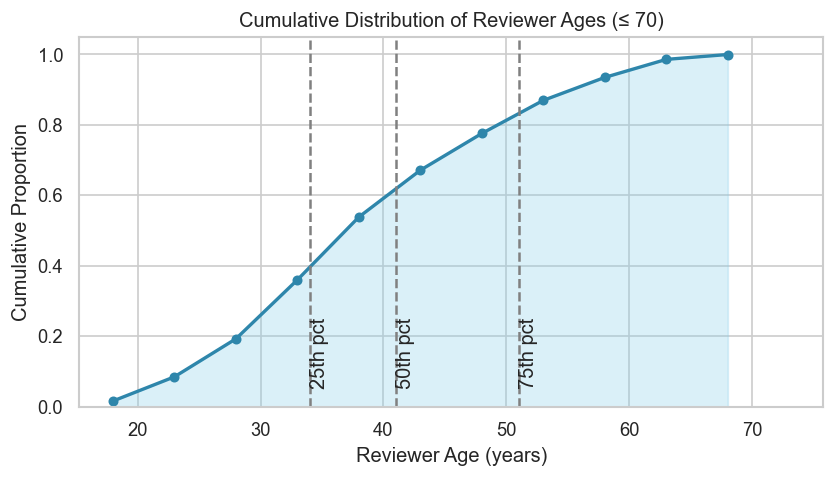

In [25]:
# Use a consistent whitegrid style and set figure size
sns.set_style('whitegrid')
plt.figure(figsize=(8,4), dpi=120)

# Keep only ages 70 or below so our chart focuses on the core group
ages = df.loc[df['Age'] <= 70, 'Age']

# Define bins in 5-year steps from the minimum age up to 70
bins = np.arange(ages.min(), 75, 5)

# Build a normalized histogram (PDF) so the area sums to 1
density, bins, _ = plt.hist(ages, bins=bins, density=True, alpha=0)

# Turn the PDF into a CDF by cumulatively summing
cum_prop = np.cumsum(density * np.diff(bins))

# Shade under the curve for visual emphasis and plot the line with markers
plt.fill_between(bins[:-1], cum_prop, color='skyblue', alpha=0.3)
plt.plot(bins[:-1], cum_prop, color='#2E86AB', linewidth=2, marker='o', markersize=5)

# Add dashed lines at the 25th, 50th, and 75th percentiles for quick reference
q1, med, q3 = ages.quantile([0.25, 0.5, 0.75])
for q, label in zip([q1, med, q3], ['25th', '50th', '75th']):
    plt.axvline(q, linestyle='--', color='gray')
    plt.text(q, 0.05, f"{label} pct", rotation=90, va='bottom')

# Final touches: title and axis labels
plt.title('Cumulative Distribution of Reviewer Ages (≤ 70)')
plt.xlabel('Reviewer Age (years)')
plt.ylabel('Cumulative Proportion')
plt.show()


## Build and Prepare the Modeling Pipeline

In [27]:


# Custom text cleaner: lemmatizes, lowercases, and filters out stopwords/punctuation
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='en_core_web_sm'):
        self.model_name = model_name
        self.nlp = None
    def fit(self, X, y=None):
        self.nlp = spacy.load(self.model_name, disable=['parser','ner'])
        return self
    def transform(self, X):
        return [
            " ".join(
                token.lemma_.lower()
                for token in doc
                if not (token.is_stop or token.is_punct or token.like_num)
            )
            for doc in self.nlp.pipe(X, batch_size=100)
        ]

# Numeric pipeline: fill missing values and scale to a common range
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler())
])

# Categorical pipeline: replace missing with 'missing' then one-hot encode
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

# Text pipeline: clean raw text then vectorize with TF-IDF (unigrams + bigrams)
text_transformer = Pipeline([
    ('clean', TextCleaner()),
    ('vect',  TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000))
])

# Combine numeric, categorical, and text pipelines into one preprocessor
preprocessor = ColumnTransformer([
    ('numeric',     numeric_transformer,   ['Age','Positive Feedback Count','Review_Length','Excl_Count']),
    ('categorical', categorical_transformer, ['Division Name','Department Name','Class Name']),
    ('text',        text_transformer,      'Review Text')
])

# Wrap preprocessing and a Random Forest classifier into a single pipeline
model_pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf',   RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define the hyperparameter search space for the Random Forest
search_params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth':    [10, 20, None]
}

# Use a Halving Random Search to find the best parameters more efficiently
model_search = HalvingRandomSearchCV(
    model_pipeline,
    param_distributions=search_params,
    factor=2, cv=5, scoring='accuracy', verbose=1, n_jobs=-1
)


## Training Pipeline

In [29]:
# Custom text cleaner: loads spaCy, lemmatizes, lowercases, and drops stopwords/punctuation/numbers
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='en_core_web_sm'):
        self.model_name = model_name
        self.nlp = None
    def fit(self, X, y=None):
        self.nlp = spacy.load(self.model_name, disable=['parser','ner'])
        return self
    def transform(self, X):
        return [
            " ".join(
                token.lemma_.lower()
                for token in doc
                if not (token.is_stop or token.is_punct or token.like_num)
            )
            for doc in self.nlp.pipe(X, batch_size=100)
        ]

# Numeric pipeline: fill in missing values with the median, then scale everything to the same range
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# Categorical pipeline: replace any missing categories with 'missing', then one-hot encode
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Text pipeline: clean up raw reviews, then vectorize with TF-IDF (including unigrams and bigrams)
text_transformer = Pipeline([
    ('clean', TextCleaner()),
    ('vect',  TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000))
])

# Combine numeric, categorical, and text steps into one preprocessor
preprocessor = ColumnTransformer([
    ('numeric',     numeric_transformer,   ['Age','Positive Feedback Count','Review_Length','Excl_Count']),
    ('categorical', categorical_transformer,['Division Name','Department Name','Class Name']),
    ('text',        text_transformer,      'Review Text')
])

# Wrap preprocessing and a Random Forest into a single pipeline
model_pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf',   RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define the search space for our Random Forest parameters
search_params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth':    [10, 20, None]
}

# Use a halving random search to find the best settings efficiently
model_search = HalvingRandomSearchCV(
    model_pipeline,
    param_distributions=search_params,
    factor=2,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)


## Fine-Tuning Pipeline

In [31]:
model_search.fit(X_train, y_train)
print("Best hyperparameters:", model_search.best_params_)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 10
min_resources_: 20
max_resources_: 16597
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 20
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/envs/dsnd-pipelines/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=829. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 5
n_resources: 40
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 80
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 160
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters: {'rf__n_estimators': 200, 'rf__max_depth': None}


## Final Model Assessment: Accuracy & Confusion Matrix

Test Accuracy: 0.8525745257452575
Model Performance (After Tuning)
               precision    recall  f1-score   support

           0       0.73      0.27      0.39       327
           1       0.86      0.98      0.92      1518

    accuracy                           0.85      1845
   macro avg       0.80      0.62      0.65      1845
weighted avg       0.84      0.85      0.82      1845



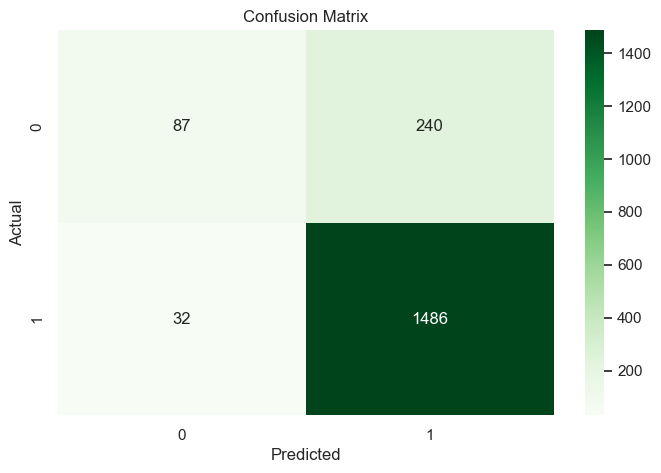

In [33]:

best_model = model_search.best_estimator_
y_pred     = best_model.predict(X_test)

# Print overall accuracy and a detailed breakdown of precision, recall, and F1
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Model Performance (After Tuning)\n", classification_report(y_test, y_pred))

# Visualize a confusion matrix to spot where we're getting predictions right (and where we're not)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
